In [ ]:

import numpy as np
from tqdm import tqdm
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision
import torch
import scipy.io
import matplotlib.pyplot as plt

In [ ]:
# Mounting colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Stanfard Car Dataset directory
base_path = '/content/drive/My Drive/301_Project/Datasets/Stanfard_Car_Datasets'
# Train and test images dataset path
cars_train_path = f'{base_path}/cars_train/cars_train'
cars_test_path = f'{base_path}/cars_test/cars_test'
# Annotations mat file path
annotations_path = f'{base_path}/cars_annos.mat'
annotations_train_path = f'{base_path}/cars_train_annos.mat'
annotations_test_path = f'{base_path}/cars_test_annos.mat'

Mounted at /content/drive


In [ ]:
train_mat = scipy.io.loadmat(annotations_train_path)
train_annotations = train_mat['annotations'][0]

test_mat = scipy.io.loadmat(annotations_test_path)
test_annotations = test_mat['annotations'][0]

training_image_label_dictionary = {}

for annotation in train_annotations:
    filename = annotation[-1][0]
    label = annotation[-2][0][0] - 1  # Subtract 1 to make labels 0-indexed
    training_image_label_dictionary[filename] = label

testing_image_label_dictionary = {}

for annotation in test_annotations:
    filename = annotation[-1][0]
    label = annotation[-2][0][0] - 1  # Subtract 1 to make labels 0-indexed
    testing_image_label_dictionary[filename] = label

class_names = [i[0] for i in scipy.io.loadmat(annotations_path)['class_names'][0]]
print(f'There are {len(class_names)} classes in the dataset')

There are 196 classes in the dataset


In [ ]:
class StanfordCarsDataset(Dataset):
    def __init__(self, directory, image_label_dict, transform=None):
        self.directory = directory
        self.image_label_dict = image_label_dict
        self.transform = transform
        self.images = list(image_label_dict.keys())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.directory, self.images[idx])
        image = Image.open(image_path).convert('RGB')
        label = self.image_label_dict[self.images[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label

train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.RandomHorizontalFlip(), # Flip the image horizontally with a 50% chance
        # transforms.RandomRotation(20), # Rotate image by 20 degrees
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# initialize your datasets
train_dataset = StanfordCarsDataset(cars_train_path, training_image_label_dictionary, train_transforms)
test_dataset = StanfordCarsDataset(cars_test_path, testing_image_label_dictionary, test_transforms)

## Finetune ViT

## Hyperparameter Tuning - Round 1

In [ ]:
class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.vit = torchvision.models.vit_b_16(pretrained=True)  # Assuming this is the vit model
        # Modification to the classification head here, if necessary
        self.fc = nn.Linear(1000, num_classes)  # Adjust as per the original model specification

    def forward(self, x):
        x = self.vit(x)
        x = self.fc(x)
        return x


In [ ]:
pip install optuna


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 11.6 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna.trial import TrialState
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.models as models
from tqdm import tqdm
import numpy as np

# Set logging level
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective(trial):
    # Due to insufficient computational resourse, only tune for lr, batch_size, and unfreezed layers
    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.1])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    num_unfreeze_layers = trial.suggest_categorical('num_unfreeze_layers', [1, 3, 5])


    # Setup model and unfreeze appropriate blocks
    model = ViTModel(num_classes=len(class_names)).to(device)
    total_params = len(list(model.vit.parameters()))

    # Freeze all parameters initially
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze layers
    encoder_layers = model.vit.encoder.layers
    num_blocks = len(encoder_layers)  # Total number of encoder blocks
    blocks_to_unfreeze = num_blocks - num_unfreeze_layers

    # Unfreeze the specified last layers
    for i in range(blocks_to_unfreeze, num_blocks):
        for param in encoder_layers[i].parameters():
            param.requires_grad = True

    params_to_optimize = [param for param in model.parameters() if param.requires_grad]
    if not params_to_optimize:
        raise ValueError("No parameters to optimize. Check the logic for unfreezing layers.")

    optimizer = torch.optim.Adam(params_to_optimize, lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    # Training loop
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    model.train()
    for epoch in range(10):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation loop
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    model.eval()
    total_correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total_correct += torch.sum(preds == labels.data)

    accuracy = total_correct.double() / len(test_loader.dataset)
    return accuracy.item()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2024-04-19 21:14:12,906] A new study created in memory with name: no-name-a0bdbded-5a39-4d35-a586-d1f1c6c90706
[I 2024-04-19 21:32:00,301] Trial 0 finished with value: 0.694192264643701 and parameters: {'learning_rate': 0.001, 'batch_size': 16, 'num_unfreeze_layers': 5}. Best is trial 0 with value: 0.694192264643701.
[I 2024-04-19 21:47:58,955] Trial 1 finished with value: 0.2055714463375202 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'num_unfreeze_layers': 1}. Best is trial 0 with value: 0.694192264643701.
[I 2024-04-19 22:04:30,333] Trial 2 finished with value: 0.6703146374829001 and parameters: {'learning_rate': 0.001, 'batch_size': 32, 'num_unfreeze_layers': 3}. Best is trial 0 with value: 0.694192264643701.
[I 2024-04-19 22:20:55,011] Trial 3 finished with value: 0.481034697176968 and parameters: {'learning_rate': 0.01, 'batch_size': 32, 'num_unfreeze_layers': 3}. Best is trial 0 with value: 0.694192264643701.
[I 2024-04-19 22:37:31,583] Trial 4 finished with value

#### I terminated early as the pattern has emerged and its good to further fine tune based on existing based trial

In [ ]:
# Best hyperparameters
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value: 0.7426936948140778
  Params: 
    learning_rate: 0.001
    batch_size: 64
    num_unfreeze_layers: 5


In [ ]:
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

# Optimization History
history_plot = plot_optimization_history(study)
history_plot.show()

# Parameter Importances
importance_plot = plot_param_importances(study)
importance_plot.show()

# Slice Plot
slice_plot = plot_slice(study)
slice_plot.show()

# Contour Plot of Parameter Interactions
contour_plot = plot_contour(study, params=['learning_rate', 'batch_size', 'num_unfreeze_layers'])
contour_plot.show()


## Hyperparameter Tuning - Round 2

In [ ]:
import optuna
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.models as models
from tqdm import tqdm
import numpy as np

# Set logging level
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective(trial):
    # Tuning hyperparameters more narrowly around previously successful values
    learning_rate = trial.suggest_float('learning_rate', 0.0005, 0.002, log=True)
    batch_size = trial.suggest_categorical('batch_size', [48, 64, 80])
    num_unfreeze_layers = trial.suggest_categorical('num_unfreeze_layers', [4, 5, 6])

    # Setup model and unfreeze appropriate blocks
    model = ViTModel(num_classes=len(class_names)).to(device)

    # Freeze all parameters initially
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze layers
    encoder_layers = model.vit.encoder.layers
    num_blocks = len(encoder_layers)  # Total number of encoder blocks
    blocks_to_unfreeze = num_blocks - num_unfreeze_layers

    # Unfreeze the specified last layers
    for i in range(blocks_to_unfreeze, num_blocks):
        for param in encoder_layers[i].parameters():
            param.requires_grad = True

    params_to_optimize = [param for param in model.parameters() if param.requires_grad]
    if not params_to_optimize:
        raise ValueError("No parameters to optimize. Check the logic for unfreezing layers.")

    optimizer = torch.optim.Adam(params_to_optimize, lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    # Training loop
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    model.train()
    for epoch in range(10):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation loop
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    model.eval()
    total_correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total_correct += torch.sum(preds == labels.data)

    accuracy = total_correct.double() / len(test_loader.dataset)
    print(f"Trial {trial.number}: Accuracy={accuracy}")
    return accuracy.item()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)


[I 2024-04-19 04:50:45,590] A new study created in memory with name: no-name-8c5f97ce-edc7-43d1-8331-513a49e64877
[I 2024-04-19 05:23:29,896] Trial 0 finished with value: 0.7196866061435144 and parameters: {'learning_rate': 0.0015872857929925582, 'batch_size': 80, 'num_unfreeze_layers': 4}. Best is trial 0 with value: 0.7196866061435144.


Trial 0: Accuracy=0.7196866061435144


[I 2024-04-19 05:40:00,693] Trial 1 finished with value: 0.7266509140654147 and parameters: {'learning_rate': 0.0006222790304155606, 'batch_size': 80, 'num_unfreeze_layers': 4}. Best is trial 1 with value: 0.7266509140654147.


Trial 1: Accuracy=0.7266509140654147


[I 2024-04-19 05:57:02,644] Trial 2 finished with value: 0.6106205695808978 and parameters: {'learning_rate': 0.001425198817890453, 'batch_size': 48, 'num_unfreeze_layers': 6}. Best is trial 1 with value: 0.7266509140654147.


Trial 2: Accuracy=0.6106205695808978


[I 2024-04-19 06:13:53,061] Trial 3 finished with value: 0.7574928491481159 and parameters: {'learning_rate': 0.0010388248451226546, 'batch_size': 80, 'num_unfreeze_layers': 4}. Best is trial 3 with value: 0.7574928491481159.


Trial 3: Accuracy=0.7574928491481159


[I 2024-04-19 06:30:46,293] Trial 4 finished with value: 0.7252829250093271 and parameters: {'learning_rate': 0.0005924317719159515, 'batch_size': 80, 'num_unfreeze_layers': 5}. Best is trial 3 with value: 0.7574928491481159.


Trial 4: Accuracy=0.7252829250093271


[I 2024-04-19 06:47:06,360] Trial 5 finished with value: 0.7098619574679765 and parameters: {'learning_rate': 0.0013111087418887942, 'batch_size': 64, 'num_unfreeze_layers': 4}. Best is trial 3 with value: 0.7574928491481159.


Trial 5: Accuracy=0.7098619574679765


[I 2024-04-19 07:03:43,592] Trial 6 finished with value: 0.7679393110309662 and parameters: {'learning_rate': 0.0006065392030251867, 'batch_size': 48, 'num_unfreeze_layers': 4}. Best is trial 6 with value: 0.7679393110309662.


Trial 6: Accuracy=0.7679393110309662


[I 2024-04-19 07:20:17,248] Trial 7 finished with value: 0.73436139783609 and parameters: {'learning_rate': 0.0006230034199178031, 'batch_size': 80, 'num_unfreeze_layers': 4}. Best is trial 6 with value: 0.7679393110309662.


Trial 7: Accuracy=0.73436139783609


[I 2024-04-19 07:37:09,668] Trial 8 finished with value: 0.7281432657629647 and parameters: {'learning_rate': 0.0011270540235740632, 'batch_size': 64, 'num_unfreeze_layers': 5}. Best is trial 6 with value: 0.7679393110309662.


Trial 8: Accuracy=0.7281432657629647


[I 2024-04-19 07:53:59,227] Trial 9 finished with value: 0.7188160676532769 and parameters: {'learning_rate': 0.0011044163942570229, 'batch_size': 80, 'num_unfreeze_layers': 4}. Best is trial 6 with value: 0.7679393110309662.


Trial 9: Accuracy=0.7188160676532769


[I 2024-04-19 08:11:05,219] Trial 10 finished with value: 0.7164531774654893 and parameters: {'learning_rate': 0.0007669985257488634, 'batch_size': 48, 'num_unfreeze_layers': 6}. Best is trial 6 with value: 0.7679393110309662.


Trial 10: Accuracy=0.7164531774654893


[I 2024-04-19 08:27:50,909] Trial 11 finished with value: 0.7771421464991916 and parameters: {'learning_rate': 0.0008403972172337477, 'batch_size': 48, 'num_unfreeze_layers': 4}. Best is trial 11 with value: 0.7771421464991916.


Trial 11: Accuracy=0.7771421464991916


[I 2024-04-19 08:44:28,096] Trial 12 finished with value: 0.7574928491481159 and parameters: {'learning_rate': 0.0007713861898314177, 'batch_size': 48, 'num_unfreeze_layers': 4}. Best is trial 11 with value: 0.7771421464991916.


Trial 12: Accuracy=0.7574928491481159


[I 2024-04-19 09:02:00,102] Trial 13 finished with value: 0.761721178957841 and parameters: {'learning_rate': 0.0005044107435480785, 'batch_size': 48, 'num_unfreeze_layers': 6}. Best is trial 11 with value: 0.7771421464991916.


Trial 13: Accuracy=0.761721178957841


[I 2024-04-19 09:18:59,141] Trial 14 finished with value: 0.7394602661360526 and parameters: {'learning_rate': 0.0008113733724034947, 'batch_size': 48, 'num_unfreeze_layers': 4}. Best is trial 11 with value: 0.7771421464991916.


Trial 14: Accuracy=0.7394602661360526


[I 2024-04-19 09:36:00,386] Trial 15 finished with value: 0.6864817808730257 and parameters: {'learning_rate': 0.001974249884090247, 'batch_size': 48, 'num_unfreeze_layers': 5}. Best is trial 11 with value: 0.7771421464991916.


Trial 15: Accuracy=0.6864817808730257


[I 2024-04-19 09:52:40,388] Trial 16 finished with value: 0.746922024623803 and parameters: {'learning_rate': 0.0008934096264953088, 'batch_size': 48, 'num_unfreeze_layers': 4}. Best is trial 11 with value: 0.7771421464991916.


Trial 16: Accuracy=0.746922024623803


[I 2024-04-19 10:09:18,546] Trial 17 finished with value: 0.734610123119015 and parameters: {'learning_rate': 0.0005114098940805907, 'batch_size': 64, 'num_unfreeze_layers': 4}. Best is trial 11 with value: 0.7771421464991916.


Trial 17: Accuracy=0.734610123119015


[I 2024-04-19 10:26:19,333] Trial 18 finished with value: 0.6827509016291505 and parameters: {'learning_rate': 0.0008949675772759265, 'batch_size': 48, 'num_unfreeze_layers': 6}. Best is trial 11 with value: 0.7771421464991916.


Trial 18: Accuracy=0.6827509016291505


[I 2024-04-19 10:43:21,681] Trial 19 finished with value: 0.7705509265016789 and parameters: {'learning_rate': 0.0006806254035428796, 'batch_size': 48, 'num_unfreeze_layers': 5}. Best is trial 11 with value: 0.7771421464991916.


Trial 19: Accuracy=0.7705509265016789


In [ ]:
# Best hyperparameters
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value: 0.7771421464991916
  Params: 
    learning_rate: 0.0008403972172337477
    batch_size: 48
    num_unfreeze_layers: 4


In [ ]:
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

# Optimization History
history_plot = plot_optimization_history(study)
history_plot.show()

# Parameter Importances
importance_plot = plot_param_importances(study)
importance_plot.show()

# Slice Plot
slice_plot = plot_slice(study)
slice_plot.show()

# Contour Plot of Parameter Interactions
contour_plot = plot_contour(study, params=['learning_rate', 'batch_size', 'num_unfreeze_layers'])
contour_plot.show()


## Train pretrained ViT based on best hyperparameters combination

In [ ]:
# Updated training function with scheduler
def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, total_correct = 0, 0
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total_correct += torch.sum(preds == labels.data)
    return total_loss / len(dataloader), total_correct.double() / len(dataloader.dataset)


def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_correct += torch.sum(preds == labels.data)
    return total_loss / len(dataloader), total_correct.double() / len(dataloader.dataset)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the function to unfreeze layers
def unfreeze_layers(model, num_unfreeze_layers):
    for param in model.parameters():
        param.requires_grad = False
    encoder_layers = model.vit.encoder.layers
    num_blocks = len(encoder_layers)
    blocks_to_unfreeze = num_blocks - num_unfreeze_layers
    for i in range(blocks_to_unfreeze, num_blocks):
        for param in encoder_layers[i].parameters():
            param.requires_grad = True

100%|██████████| 170/170 [03:22<00:00,  1.19s/it]


Epoch 1, Train Loss: 3.880, Train Accuracy: 0.239


100%|██████████| 168/168 [09:19<00:00,  3.33s/it]


Test Loss: 2.315, Test Accuracy: 0.552


100%|██████████| 170/170 [01:32<00:00,  1.83it/s]


Epoch 2, Train Loss: 1.279, Train Accuracy: 0.771


100%|██████████| 168/168 [01:26<00:00,  1.95it/s]


Test Loss: 1.314, Test Accuracy: 0.712


100%|██████████| 170/170 [01:33<00:00,  1.82it/s]


Epoch 3, Train Loss: 0.403, Train Accuracy: 0.927


100%|██████████| 168/168 [01:25<00:00,  1.95it/s]


Test Loss: 1.028, Test Accuracy: 0.772


100%|██████████| 170/170 [01:35<00:00,  1.78it/s]


Epoch 4, Train Loss: 0.189, Train Accuracy: 0.965


100%|██████████| 168/168 [01:30<00:00,  1.85it/s]


Test Loss: 1.012, Test Accuracy: 0.774


100%|██████████| 170/170 [01:33<00:00,  1.82it/s]


Epoch 5, Train Loss: 0.112, Train Accuracy: 0.982


100%|██████████| 168/168 [01:26<00:00,  1.94it/s]


Test Loss: 0.971, Test Accuracy: 0.779


100%|██████████| 170/170 [01:33<00:00,  1.82it/s]


Epoch 6, Train Loss: 0.159, Train Accuracy: 0.971


100%|██████████| 168/168 [01:27<00:00,  1.92it/s]


Test Loss: 1.392, Test Accuracy: 0.687


100%|██████████| 170/170 [01:38<00:00,  1.72it/s]


Epoch 7, Train Loss: 0.252, Train Accuracy: 0.956


100%|██████████| 168/168 [01:29<00:00,  1.87it/s]


Test Loss: 1.263, Test Accuracy: 0.716


100%|██████████| 170/170 [01:33<00:00,  1.82it/s]


Epoch 8, Train Loss: 0.117, Train Accuracy: 0.979


100%|██████████| 168/168 [01:32<00:00,  1.82it/s]


Test Loss: 1.052, Test Accuracy: 0.767


100%|██████████| 170/170 [01:42<00:00,  1.66it/s]


Epoch 9, Train Loss: 0.077, Train Accuracy: 0.986


100%|██████████| 168/168 [01:34<00:00,  1.79it/s]


Test Loss: 1.150, Test Accuracy: 0.747


100%|██████████| 170/170 [01:36<00:00,  1.75it/s]


Epoch 10, Train Loss: 0.062, Train Accuracy: 0.989


100%|██████████| 168/168 [01:33<00:00,  1.80it/s]


Test Loss: 1.131, Test Accuracy: 0.754


100%|██████████| 170/170 [01:37<00:00,  1.74it/s]


Epoch 11, Train Loss: 0.103, Train Accuracy: 0.979


100%|██████████| 168/168 [01:27<00:00,  1.93it/s]


Test Loss: 1.279, Test Accuracy: 0.723


100%|██████████| 170/170 [01:32<00:00,  1.83it/s]


Epoch 12, Train Loss: 0.071, Train Accuracy: 0.986


100%|██████████| 168/168 [01:25<00:00,  1.95it/s]


Test Loss: 1.242, Test Accuracy: 0.741


100%|██████████| 170/170 [01:34<00:00,  1.80it/s]


Epoch 13, Train Loss: 0.098, Train Accuracy: 0.981


100%|██████████| 168/168 [01:29<00:00,  1.89it/s]


Test Loss: 1.214, Test Accuracy: 0.734


100%|██████████| 170/170 [01:36<00:00,  1.77it/s]


Epoch 14, Train Loss: 0.114, Train Accuracy: 0.978


100%|██████████| 168/168 [01:27<00:00,  1.92it/s]


Test Loss: 1.295, Test Accuracy: 0.717


100%|██████████| 170/170 [01:33<00:00,  1.81it/s]


Epoch 15, Train Loss: 0.109, Train Accuracy: 0.977


100%|██████████| 168/168 [01:27<00:00,  1.91it/s]


Test Loss: 1.293, Test Accuracy: 0.721


100%|██████████| 170/170 [01:33<00:00,  1.82it/s]


Epoch 16, Train Loss: 0.074, Train Accuracy: 0.986


100%|██████████| 168/168 [01:28<00:00,  1.89it/s]


Test Loss: 1.122, Test Accuracy: 0.760


100%|██████████| 170/170 [01:33<00:00,  1.82it/s]


Epoch 17, Train Loss: 0.021, Train Accuracy: 0.997


100%|██████████| 168/168 [01:27<00:00,  1.92it/s]


Test Loss: 0.952, Test Accuracy: 0.796


100%|██████████| 170/170 [01:34<00:00,  1.81it/s]


Epoch 18, Train Loss: 0.012, Train Accuracy: 0.998


100%|██████████| 168/168 [01:28<00:00,  1.90it/s]


Test Loss: 0.921, Test Accuracy: 0.805


100%|██████████| 170/170 [01:34<00:00,  1.81it/s]


Epoch 19, Train Loss: 0.011, Train Accuracy: 0.998


100%|██████████| 168/168 [01:26<00:00,  1.94it/s]


Test Loss: 0.919, Test Accuracy: 0.804


100%|██████████| 170/170 [01:33<00:00,  1.82it/s]


Epoch 20, Train Loss: 0.010, Train Accuracy: 0.998


100%|██████████| 168/168 [01:25<00:00,  1.96it/s]


Test Loss: 0.919, Test Accuracy: 0.806


100%|██████████| 170/170 [01:33<00:00,  1.81it/s]


Epoch 21, Train Loss: 0.010, Train Accuracy: 0.998


100%|██████████| 168/168 [01:26<00:00,  1.95it/s]


Test Loss: 0.918, Test Accuracy: 0.807


100%|██████████| 170/170 [01:33<00:00,  1.83it/s]


Epoch 22, Train Loss: 0.009, Train Accuracy: 0.998


100%|██████████| 168/168 [01:26<00:00,  1.95it/s]


Test Loss: 0.922, Test Accuracy: 0.809


100%|██████████| 170/170 [01:30<00:00,  1.87it/s]


Epoch 23, Train Loss: 0.009, Train Accuracy: 0.997


100%|██████████| 168/168 [01:24<00:00,  2.00it/s]


Test Loss: 0.921, Test Accuracy: 0.810


100%|██████████| 170/170 [01:30<00:00,  1.87it/s]


Epoch 24, Train Loss: 0.009, Train Accuracy: 0.998


100%|██████████| 168/168 [01:23<00:00,  2.01it/s]


Test Loss: 0.926, Test Accuracy: 0.810


100%|██████████| 170/170 [01:30<00:00,  1.87it/s]


Epoch 25, Train Loss: 0.009, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  1.99it/s]


Test Loss: 0.930, Test Accuracy: 0.812


100%|██████████| 170/170 [01:31<00:00,  1.86it/s]


Epoch 26, Train Loss: 0.008, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  1.98it/s]


Test Loss: 0.939, Test Accuracy: 0.811


100%|██████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 27, Train Loss: 0.008, Train Accuracy: 0.998


100%|██████████| 168/168 [01:25<00:00,  1.97it/s]


Test Loss: 0.938, Test Accuracy: 0.812


100%|██████████| 170/170 [01:29<00:00,  1.90it/s]


Epoch 28, Train Loss: 0.008, Train Accuracy: 0.998


100%|██████████| 168/168 [01:23<00:00,  2.01it/s]


Test Loss: 0.943, Test Accuracy: 0.813


100%|██████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 29, Train Loss: 0.007, Train Accuracy: 0.998


100%|██████████| 168/168 [01:23<00:00,  2.00it/s]


Test Loss: 0.958, Test Accuracy: 0.812


100%|██████████| 170/170 [01:31<00:00,  1.86it/s]


Epoch 30, Train Loss: 0.008, Train Accuracy: 0.998


100%|██████████| 168/168 [01:23<00:00,  2.01it/s]


Test Loss: 0.961, Test Accuracy: 0.813


100%|██████████| 170/170 [01:30<00:00,  1.89it/s]


Epoch 31, Train Loss: 0.008, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  1.99it/s]


Test Loss: 0.960, Test Accuracy: 0.816


100%|██████████| 170/170 [01:30<00:00,  1.89it/s]


Epoch 32, Train Loss: 0.007, Train Accuracy: 0.998


100%|██████████| 168/168 [01:23<00:00,  2.01it/s]


Test Loss: 0.976, Test Accuracy: 0.814


100%|██████████| 170/170 [01:31<00:00,  1.86it/s]


Epoch 33, Train Loss: 0.006, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  1.99it/s]


Test Loss: 0.976, Test Accuracy: 0.815


100%|██████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 34, Train Loss: 0.006, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  2.00it/s]


Test Loss: 0.983, Test Accuracy: 0.815


100%|██████████| 170/170 [01:29<00:00,  1.90it/s]


Epoch 35, Train Loss: 0.006, Train Accuracy: 0.998


100%|██████████| 168/168 [01:22<00:00,  2.04it/s]


Test Loss: 0.988, Test Accuracy: 0.815


100%|██████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 36, Train Loss: 0.006, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  2.00it/s]


Test Loss: 0.989, Test Accuracy: 0.815


100%|██████████| 170/170 [01:29<00:00,  1.89it/s]


Epoch 37, Train Loss: 0.006, Train Accuracy: 0.997


100%|██████████| 168/168 [01:23<00:00,  2.00it/s]


Test Loss: 0.996, Test Accuracy: 0.816


100%|██████████| 170/170 [01:29<00:00,  1.89it/s]


Epoch 38, Train Loss: 0.006, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  1.99it/s]


Test Loss: 1.003, Test Accuracy: 0.817


100%|██████████| 170/170 [01:31<00:00,  1.87it/s]


Epoch 39, Train Loss: 0.006, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  1.99it/s]


Test Loss: 1.007, Test Accuracy: 0.817


100%|██████████| 170/170 [01:29<00:00,  1.90it/s]


Epoch 40, Train Loss: 0.006, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  1.99it/s]


Test Loss: 1.014, Test Accuracy: 0.816


100%|██████████| 170/170 [01:30<00:00,  1.89it/s]


Epoch 41, Train Loss: 0.006, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  1.99it/s]


Test Loss: 1.022, Test Accuracy: 0.815


100%|██████████| 170/170 [01:31<00:00,  1.85it/s]


Epoch 42, Train Loss: 0.006, Train Accuracy: 0.998


100%|██████████| 168/168 [01:23<00:00,  2.01it/s]


Test Loss: 1.023, Test Accuracy: 0.815


100%|██████████| 170/170 [01:30<00:00,  1.87it/s]


Epoch 43, Train Loss: 0.006, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  1.99it/s]


Test Loss: 1.031, Test Accuracy: 0.816


100%|██████████| 170/170 [01:29<00:00,  1.89it/s]


Epoch 44, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  2.00it/s]


Test Loss: 1.034, Test Accuracy: 0.817


100%|██████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 45, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:22<00:00,  2.03it/s]


Test Loss: 1.039, Test Accuracy: 0.816


100%|██████████| 170/170 [01:30<00:00,  1.87it/s]


Epoch 46, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:25<00:00,  1.96it/s]


Test Loss: 1.044, Test Accuracy: 0.815


100%|██████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 47, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:23<00:00,  2.00it/s]


Test Loss: 1.048, Test Accuracy: 0.814


100%|██████████| 170/170 [01:32<00:00,  1.83it/s]


Epoch 48, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  1.99it/s]


Test Loss: 1.051, Test Accuracy: 0.815


 22%|██▏       | 37/170 [00:21<01:01,  2.15it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d061875ed40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d061875ed40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdow

Epoch 49, Train Loss: 0.005, Train Accuracy: 0.998


  0%|          | 0/168 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d061875ed40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7d061875ed40>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d061875ed40>Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d061875ed40><function _MultiProcessingDataLoaderIter.__del__ at 0x7d061875ed40>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in 

Test Loss: 1.060, Test Accuracy: 0.813


100%|██████████| 170/170 [01:29<00:00,  1.91it/s]


Epoch 50, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  1.98it/s]


Test Loss: 1.063, Test Accuracy: 0.813


100%|██████████| 170/170 [01:28<00:00,  1.92it/s]


Epoch 51, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:23<00:00,  2.02it/s]


Test Loss: 1.067, Test Accuracy: 0.813


100%|██████████| 170/170 [01:31<00:00,  1.87it/s]


Epoch 52, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:21<00:00,  2.06it/s]


Test Loss: 1.073, Test Accuracy: 0.813


100%|██████████| 170/170 [01:30<00:00,  1.89it/s]


Epoch 53, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:25<00:00,  1.96it/s]


Test Loss: 1.075, Test Accuracy: 0.813


100%|██████████| 170/170 [01:30<00:00,  1.89it/s]


Epoch 54, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  1.98it/s]


Test Loss: 1.087, Test Accuracy: 0.813


100%|██████████| 170/170 [01:33<00:00,  1.82it/s]


Epoch 55, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:23<00:00,  2.01it/s]


Test Loss: 1.090, Test Accuracy: 0.813


100%|██████████| 170/170 [01:33<00:00,  1.82it/s]


Epoch 56, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:26<00:00,  1.95it/s]


Test Loss: 1.092, Test Accuracy: 0.814


100%|██████████| 170/170 [01:31<00:00,  1.85it/s]


Epoch 57, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:25<00:00,  1.96it/s]


Test Loss: 1.097, Test Accuracy: 0.813


100%|██████████| 170/170 [01:32<00:00,  1.85it/s]


Epoch 58, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:23<00:00,  2.00it/s]


Test Loss: 1.102, Test Accuracy: 0.813


100%|██████████| 170/170 [01:31<00:00,  1.85it/s]


Epoch 59, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  1.99it/s]


Test Loss: 1.105, Test Accuracy: 0.813


100%|██████████| 170/170 [01:32<00:00,  1.84it/s]


Epoch 60, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:25<00:00,  1.96it/s]


Test Loss: 1.111, Test Accuracy: 0.812


100%|██████████| 170/170 [01:29<00:00,  1.90it/s]


Epoch 61, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:27<00:00,  1.92it/s]


Test Loss: 1.113, Test Accuracy: 0.812


100%|██████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 62, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:22<00:00,  2.03it/s]


Test Loss: 1.116, Test Accuracy: 0.811


100%|██████████| 170/170 [01:32<00:00,  1.85it/s]


Epoch 63, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  1.99it/s]


Test Loss: 1.123, Test Accuracy: 0.812


100%|██████████| 170/170 [01:29<00:00,  1.89it/s]


Epoch 64, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:23<00:00,  2.00it/s]


Test Loss: 1.131, Test Accuracy: 0.811


100%|██████████| 170/170 [01:33<00:00,  1.82it/s]


Epoch 65, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:22<00:00,  2.03it/s]


Test Loss: 1.140, Test Accuracy: 0.810


100%|██████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 66, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  2.00it/s]


Test Loss: 1.141, Test Accuracy: 0.811


100%|██████████| 170/170 [01:31<00:00,  1.86it/s]


Epoch 67, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:23<00:00,  2.01it/s]


Test Loss: 1.146, Test Accuracy: 0.810


100%|██████████| 170/170 [01:29<00:00,  1.91it/s]


Epoch 68, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:27<00:00,  1.92it/s]


Test Loss: 1.150, Test Accuracy: 0.810


100%|██████████| 170/170 [01:30<00:00,  1.87it/s]


Epoch 69, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  1.99it/s]


Test Loss: 1.154, Test Accuracy: 0.810


100%|██████████| 170/170 [01:34<00:00,  1.81it/s]


Epoch 70, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:23<00:00,  2.02it/s]


Test Loss: 1.157, Test Accuracy: 0.810


100%|██████████| 170/170 [01:31<00:00,  1.86it/s]


Epoch 71, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:27<00:00,  1.92it/s]


Test Loss: 1.162, Test Accuracy: 0.809


100%|██████████| 170/170 [01:30<00:00,  1.88it/s]


Epoch 72, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  1.99it/s]


Test Loss: 1.169, Test Accuracy: 0.809


100%|██████████| 170/170 [01:34<00:00,  1.79it/s]


Epoch 73, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  2.00it/s]


Test Loss: 1.171, Test Accuracy: 0.809


100%|██████████| 170/170 [01:35<00:00,  1.78it/s]


Epoch 74, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  1.99it/s]


Test Loss: 1.178, Test Accuracy: 0.809


100%|██████████| 170/170 [01:30<00:00,  1.87it/s]


Epoch 75, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:28<00:00,  1.91it/s]


Test Loss: 1.180, Test Accuracy: 0.807


100%|██████████| 170/170 [01:31<00:00,  1.85it/s]


Epoch 76, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  1.98it/s]


Test Loss: 1.181, Test Accuracy: 0.807


100%|██████████| 170/170 [01:34<00:00,  1.80it/s]


Epoch 77, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:25<00:00,  1.97it/s]


Test Loss: 1.184, Test Accuracy: 0.808


100%|██████████| 170/170 [01:32<00:00,  1.84it/s]


Epoch 78, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:29<00:00,  1.87it/s]


Test Loss: 1.188, Test Accuracy: 0.808


100%|██████████| 170/170 [01:32<00:00,  1.83it/s]


Epoch 79, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  1.99it/s]


Test Loss: 1.191, Test Accuracy: 0.808


100%|██████████| 170/170 [01:35<00:00,  1.78it/s]


Epoch 80, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:26<00:00,  1.95it/s]


Test Loss: 1.194, Test Accuracy: 0.808


100%|██████████| 170/170 [01:37<00:00,  1.75it/s]


Epoch 81, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:26<00:00,  1.94it/s]


Test Loss: 1.198, Test Accuracy: 0.808


100%|██████████| 170/170 [01:33<00:00,  1.83it/s]


Epoch 82, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:29<00:00,  1.87it/s]


Test Loss: 1.200, Test Accuracy: 0.807


100%|██████████| 170/170 [01:34<00:00,  1.80it/s]


Epoch 83, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:31<00:00,  1.84it/s]


Test Loss: 1.203, Test Accuracy: 0.807


100%|██████████| 170/170 [01:34<00:00,  1.79it/s]


Epoch 84, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:31<00:00,  1.84it/s]


Test Loss: 1.206, Test Accuracy: 0.807


100%|██████████| 170/170 [01:35<00:00,  1.79it/s]


Epoch 85, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:28<00:00,  1.91it/s]


Test Loss: 1.209, Test Accuracy: 0.807


100%|██████████| 170/170 [01:39<00:00,  1.71it/s]


Epoch 86, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:27<00:00,  1.91it/s]


Test Loss: 1.214, Test Accuracy: 0.807


100%|██████████| 170/170 [01:38<00:00,  1.72it/s]


Epoch 87, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:27<00:00,  1.91it/s]


Test Loss: 1.216, Test Accuracy: 0.807


100%|██████████| 170/170 [01:38<00:00,  1.73it/s]


Epoch 88, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:27<00:00,  1.92it/s]


Test Loss: 1.218, Test Accuracy: 0.806


100%|██████████| 170/170 [01:33<00:00,  1.81it/s]


Epoch 89, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:30<00:00,  1.87it/s]


Test Loss: 1.221, Test Accuracy: 0.806


100%|██████████| 170/170 [01:33<00:00,  1.82it/s]


Epoch 90, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:32<00:00,  1.82it/s]


Test Loss: 1.223, Test Accuracy: 0.806


100%|██████████| 170/170 [01:33<00:00,  1.81it/s]


Epoch 91, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:27<00:00,  1.93it/s]


Test Loss: 1.225, Test Accuracy: 0.806


100%|██████████| 170/170 [01:38<00:00,  1.73it/s]


Epoch 92, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:27<00:00,  1.92it/s]


Test Loss: 1.227, Test Accuracy: 0.806


100%|██████████| 170/170 [01:38<00:00,  1.72it/s]


Epoch 93, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:27<00:00,  1.91it/s]


Test Loss: 1.228, Test Accuracy: 0.806


100%|██████████| 170/170 [01:37<00:00,  1.75it/s]


Epoch 94, Train Loss: 0.004, Train Accuracy: 0.997


100%|██████████| 168/168 [01:26<00:00,  1.94it/s]


Test Loss: 1.230, Test Accuracy: 0.806


100%|██████████| 170/170 [01:34<00:00,  1.79it/s]


Epoch 95, Train Loss: 0.004, Train Accuracy: 0.998


100%|██████████| 168/168 [01:29<00:00,  1.88it/s]


Test Loss: 1.232, Test Accuracy: 0.806


100%|██████████| 170/170 [01:34<00:00,  1.80it/s]


Epoch 96, Train Loss: 0.004, Train Accuracy: 0.998


100%|██████████| 168/168 [01:30<00:00,  1.86it/s]


Test Loss: 1.234, Test Accuracy: 0.806


100%|██████████| 170/170 [01:33<00:00,  1.82it/s]


Epoch 97, Train Loss: 0.004, Train Accuracy: 0.998


100%|██████████| 168/168 [01:30<00:00,  1.86it/s]


Test Loss: 1.236, Test Accuracy: 0.805


100%|██████████| 170/170 [01:33<00:00,  1.81it/s]


Epoch 98, Train Loss: 0.005, Train Accuracy: 0.998


100%|██████████| 168/168 [01:27<00:00,  1.92it/s]


Test Loss: 1.238, Test Accuracy: 0.805


100%|██████████| 170/170 [01:34<00:00,  1.79it/s]


Epoch 99, Train Loss: 0.004, Train Accuracy: 0.998


100%|██████████| 168/168 [01:25<00:00,  1.96it/s]


Test Loss: 1.239, Test Accuracy: 0.805


100%|██████████| 170/170 [01:34<00:00,  1.80it/s]


Epoch 100, Train Loss: 0.004, Train Accuracy: 0.998


100%|██████████| 168/168 [01:24<00:00,  1.99it/s]


Test Loss: 1.239, Test Accuracy: 0.805


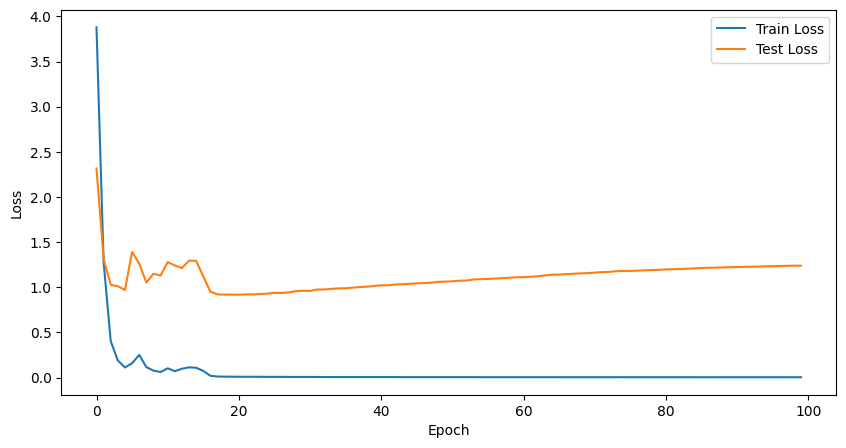

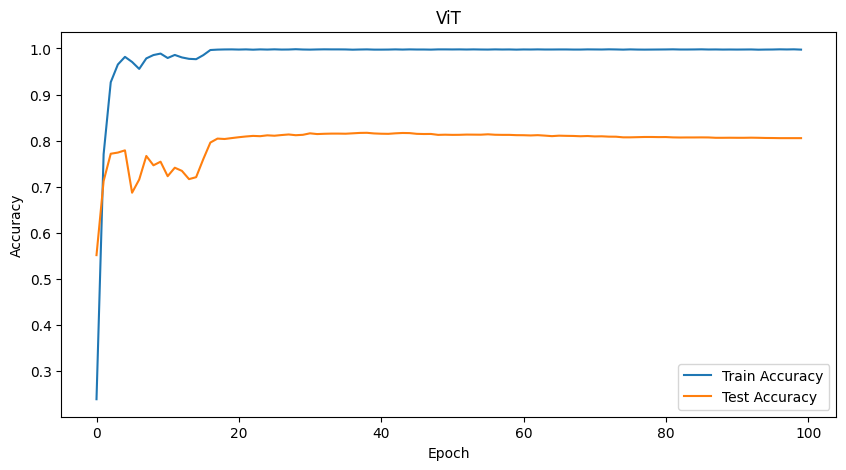

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import vit_b_16, ViT_B_16_Weights

# ViT Model
class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.vit = torchvision.models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        for param in self.vit.parameters():
            param.requires_grad = False
        self.fc = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = self.vit(x)
        return self.fc(x)

# Best hyperparameters
batch_size = 48
learning_rate = 0.00084
num_unfreeze_layers = 4
epochs = 100 # increase epochs for final training

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# model, optimizer, and loss function initialization
model = ViTModel(num_classes=len(class_names)).to(device)

# Unfreeze layers
unfreeze_layers(model, num_unfreeze_layers)

# Incorporate scheduler
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
loss_fn = nn.CrossEntropyLoss()

metrics = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

# training loop
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.3f}')

    test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
    print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}')

    # Update the learning rate scheduler with the validation/test loss
    scheduler.step(test_loss)

    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc.item())
    metrics['test_loss'].append(test_loss)
    metrics['test_acc'].append(test_acc.item())

# visualization
plt.figure(figsize=(10, 5))
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['test_acc'], label='Test Accuracy')
plt.title("ViT")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# save the model
Vit_path = '/content/drive/My Drive/301_Project/Model Development/Vit_path.pth'
torch.save(model.state_dict(), Vit_path)

# remove the model and empty the cache
del model
torch.cuda.empty_cache()